In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(os.getcwd())
path = "Fashion-Landmark-Detection-Benchmark/"

/home/aaradhya/repo/tensorflow-models/research/object_detection/fashion-landmark


In [3]:
class IdentityMetadata():
    def __init__(self, base, file):
        # dataset base directory
        self.base = base
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
def load_metadata(path):
    metadata = []
    for f in sorted(os.listdir(path)):
        # Check file extension. Allow only jpg/jpeg' files.
        ext = os.path.splitext(f)[1]
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(IdentityMetadata(path, f))
    return np.array(metadata)

In [7]:
metadata = load_metadata("../img")

In [8]:
metadata

array([../img/img_00000001.jpg, ../img/img_00000002.jpg,
       ../img/img_00000003.jpg, ..., ../img/img_00123057.jpg,
       ../img/img_00123058.jpg, ../img/img_00123059.jpg], dtype=object)

In [9]:
bbox = pd.read_csv(path+"Anno/list_bbox.txt")
bbox.head()

# joints = pd.read_csv(path+"Anno/list_joints.txt")
# joints.head()

,image_name x_1 y_1 x_2 y_2
0,img/img_00000001.jpg 053 130 289 440
1,img/img_00000002.jpg 053 095 207 208
2,img/img_00000003.jpg 041 097 244 295
3,img/img_00000004.jpg 026 059 165 186
4,img/img_00000005.jpg 126 122 349 333


In [10]:
train_test = pd.read_csv(path+"Eval/list_eval_partition.txt", sep=' ')
train_test.head()

,image_name,evaluation_status
0,img/img_00000001.jpg,train
1,img/img_00000002.jpg,val
2,img/img_00000003.jpg,train
3,img/img_00000004.jpg,train
4,img/img_00000005.jpg,train


In [11]:
landmarks = pd.read_csv(path+"Anno/list_landmarks.txt")
landmarks.head(2)

,image_name clothes_type variation_type landmark_visibility_1 landmark_location_x_1 landmark_location_y_1 landmark_visibility_2 landmark_location_x_2 landmark_location_y_2 landmark_visibility_3 landmark_location_x_3 landmark_location_y_3 landmark_visibility_4 landmark_location_x_4 landmark_location_y_4 landmark_visibility_5 landmark_location_x_5 landmark_location_y_5 landmark_visibility_6 landmark_location_x_6 landmark_location_y_6 landmark_visibility_7 landmark_location_x_7 landmark_location_y_7 landmark_visibility_8 landmark_location_x_8 landmark_location_y_8
0,img/img_00000001.jpg 1 1 1 144 156 1 221 1...
1,img/img_00000002.jpg 1 3 0 111 104 1 153 1...


In [12]:
landmarks.columns

Index(['image_name  clothes_type  variation_type  landmark_visibility_1 landmark_location_x_1 landmark_location_y_1  landmark_visibility_2 landmark_location_x_2 landmark_location_y_2  landmark_visibility_3 landmark_location_x_3 landmark_location_y_3  landmark_visibility_4 landmark_location_x_4 landmark_location_y_4  landmark_visibility_5 landmark_location_x_5 landmark_location_y_5  landmark_visibility_6 landmark_location_x_6 landmark_location_y_6  landmark_visibility_7 landmark_location_x_7 landmark_location_y_7  landmark_visibility_8 landmark_location_x_8 landmark_location_y_8 '], dtype='object')

In [15]:
landmarks.head()

,image_name clothes_type variation_type landmark_visibility_1 landmark_location_x_1 landmark_location_y_1 landmark_visibility_2 landmark_location_x_2 landmark_location_y_2 landmark_visibility_3 landmark_location_x_3 landmark_location_y_3 landmark_visibility_4 landmark_location_x_4 landmark_location_y_4 landmark_visibility_5 landmark_location_x_5 landmark_location_y_5 landmark_visibility_6 landmark_location_x_6 landmark_location_y_6 landmark_visibility_7 landmark_location_x_7 landmark_location_y_7 landmark_visibility_8 landmark_location_x_8 landmark_location_y_8
0,img/img_00000001.jpg 1 1 1 144 156 1 221 1...
1,img/img_00000002.jpg 1 3 0 111 104 1 153 1...
2,img/img_00000003.jpg 1 1 0 112 113 1 172 1...
3,img/img_00000004.jpg 1 2 0 076 074 0 108 0...
4,img/img_00000005.jpg 1 1 0 217 139 0 290 1...


image_name   clothes_type    variation_type <br/>
landmark_visibility_1 landmark_location_x_1 landmark_location_y_1  <br/>
landmark_visibility_2 landmark_location_x_2 landmark_location_y_2  <br/>
landmark_visibility_3 landmark_location_x_3 landmark_location_y_3  <br/>
landmark_visibility_4 landmark_location_x_4 landmark_location_y_4  <br/>
landmark_visibility_5 landmark_location_x_5 landmark_location_y_5  <br/>
landmark_visibility_6 landmark_location_x_6 landmark_location_y_6  <br/>
landmark_visibility_7 landmark_location_x_7 landmark_location_y_7  <br/>
landmark_visibility_8 landmark_location_x_8 landmark_location_y_8  <br/>

In [31]:
train = []
test = []
val = []
for i in range(len(landmarks)):
    row = []
    elements = (landmarks.iloc[i][0]).split()
    image_name = elements[0]
    clothes_type = int(elements[1])
    if (clothes_type==1):
        cloth_type = "upper-body clothes"
    elif (clothes_type ==2):
        cloth_type = "lower-body clothes"
    else:
        cloth_type = "full-body clothes"
    variation_type = elements[2]
    landmark = elements[3:]
    coord = []
    for j in range(int(len(landmark)/3)):
        coord.append([int(landmark[3*j+1]),int(landmark[3*j+2])])
    x,y,w,h = cv2.boundingRect(np.array(coord))
    row.append(image_name)
    row.append(cloth_type)
    #row.append(int(variation_type))
    row.append(int(h))
    row.append(int(w))
    row.append(int(w)+int(x)) #xmax
    row.append(int(x))   #xmin
    row.append(int(h)+int(y)) #ymax
    row.append(int(y))   #xmin
    #row.append(np.array(bbox))
    if(train_test['evaluation_status'][i]=='train'):
        train.append(row)
    elif(train_test['evaluation_status'][i]=='val'):
        val.append(row)
    else:
        test.append(row)

In [32]:
train = pd.DataFrame(train, columns = ['filename', 'class', 'height', 'width', 'xmax', 'xmin', 'ymax', 'ymin'])
train.shape

(83033, 8)

In [33]:
train.to_csv('train.csv')

In [34]:
train.head()

,filename,class,height,width,xmax,xmin,ymax,ymin
0,img/img_00000001.jpg,upper-body clothes,257,165,251,86,413,156
1,img/img_00000003.jpg,upper-body clothes,165,142,211,69,278,113
2,img/img_00000004.jpg,upper-body clothes,106,98,143,45,175,69
3,img/img_00000005.jpg,upper-body clothes,176,169,329,160,315,139
4,img/img_00000006.jpg,upper-body clothes,86,52,105,53,136,50


In [35]:
test = pd.DataFrame(test, columns = ['filename', 'class', 'height', 'width', 'xmax', 'xmin', 'ymax', 'ymin'])
print("test shape: ",test.shape)
test.to_csv('test.csv')

val = pd.DataFrame(val, columns = ['filename', 'class', 'height', 'width', 'xmax', 'xmin', 'ymax', 'ymin'])
print("val shape: ",val.shape)
val.to_csv('val.csv')

test shape:  (19991, 8)
val shape:  (19992, 8)


bbox: x,y,w,h

1. n clothes type, "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes. Upper-body clothes possess six fashion landmarks, lower-body clothes possess four fashion landmarks, full-body clothes possess eight fashion landmarks;
2. In variation type, "1" represents normal pose, "2" represents medium pose, "3" represents large pose, "4" represents medium zoom-in, "5" represents large zoom-in;
3. For upper-body clothes, landmark annotations are listed in the order of ["left collar", "right collar", "left sleeve", "right sleeve", "left hem", "right hem"]; For lower-body clothes, landmark annotations are listed in the order of ["left waistline", "right waistline", "left hem", "right hem"]; For upper-body clothes, landmark annotations are listed in the order of ["left collar", "right collar", "left sleeve", "right sleeve", "left waistline", "right waistline", "left hem", "right hem"]

-------------------------------

In [12]:
# x,y,w,h = cv2.boundingRect(list[0])
# cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
# cv2.imshow()

# rect = cv.minAreaRect(cnt)
# box = cv.boxPoints(rect)
# box = np.int0(box)
# cv.drawContours(img,[box],0,(0,0,255),2)

In [43]:
import matplotlib.pyplot as plt 
from matplotlib import patches 

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    original = load_image(metadata[img_index].image_path())
    
    landmark = (landmarks.iloc[img_index][0]).split()[3:]
    coord = []
    print(landmark)
    for j in range(int(len(landmark)/3)):
        coord.append([int(landmark[3*j+1]),int(landmark[3*j+2])])
    print(coord)
    x,y,w,h = cv2.boundingRect(np.array(coord))
    print(x,y,w,h)
    
    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    plt.gca().add_patch(patches.Rectangle((x, y), w, h, fill=False, color='red'))

    # Show landmarks
    plt.subplot(133)
    plt.imshow(original)
    plt.gca().add_patch(patches.Polygon(coord, fill=False, color='red'))

['1', '160', '082', '1', '194', '073', '1', '144', '095', '0', '213', '080', '0', '154', '177', '0', '221', '172', '0', '136', '409', '0', '227', '403']
[[160, 82], [194, 73], [144, 95], [213, 80], [154, 177], [221, 172], [136, 409], [227, 403]]
136 73 92 337


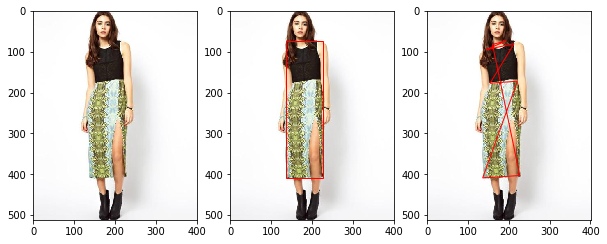

In [50]:
show_original_and_aligned(112)

['1', '140', '181', '1', '204', '187', '0', '111', '308', '0', '305', '219']
[[140, 181], [204, 187], [111, 308], [305, 219]]
111 181 195 128


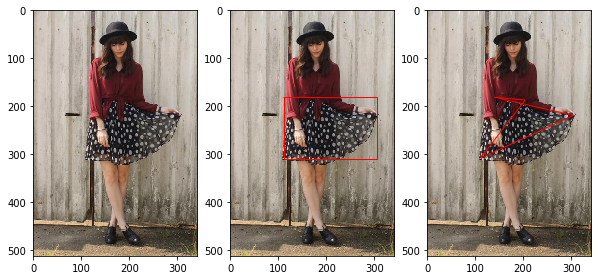

In [53]:
show_original_and_aligned(36)